In [2]:
from reni.field_components.vn_layers import *
from scipy.spatial.transform import Rotation
from matplotlib import pyplot as plt
import numpy as np

# x: point features of shape [B, N_feat, 3, N_samples, ...]
B = 1
latent_dim = 36
num_latents = 5

x = torch.rand(latent_dim, 3, num_latents).unsqueeze(0)

invariant_transform = VNStdFeature(in_channels=latent_dim, dim=4, normalize_frame=True, share_nonlinearity=False)

x_out = invariant_transform(x)

# Generate a random rotation
rot = Rotation.random(num=1)

# Convert the rotation to a rotation matrix
rot_matrix_np = rot.as_matrix()

# Convert the numpy array to a PyTorch tensor
rot_tensor = torch.tensor(rot_matrix_np, dtype=torch.float).squeeze()

# Apply rotation to x by matrix multiplication.
# Assume x is of size (B, latent_dim, 3, num_latents).
# So, we rotate the third dimension, which represents the 3D coordinates.
x_rotated = torch.einsum('ij,bfjn->bfin', rot_tensor, x)

# Now process x and x_rotated through the vn_mlp
x_out, z_out = invariant_transform(x)
x_rotated_out, z_rotated_out = invariant_transform(x_rotated)

print('Rotation Invariant = ' + str(torch.isclose(x_out, x_rotated_out, atol=1e-5).all().item()) + ' for eps = 1e-5')

Rotation Invariant = False for eps = 1e-5


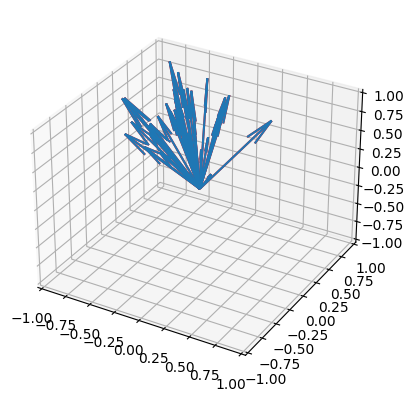

In [111]:
x_out = x_out[0, :, :, 0] # (latent_dim, 3)
x_out = x_out.detach().numpy()

x_out_rotated = x_rotated_out[0, :, :, 0] # (latent_dim, 3)
x_out_rotated = x_out_rotated.detach().numpy()

# plot all 3D vectors starting from origin
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(np.zeros(latent_dim), np.zeros(latent_dim), np.zeros(latent_dim), x_out[:, 0], x_out[:, 1], x_out[:, 2])
# in red
ax.quiver(np.zeros(latent_dim), np.zeros(latent_dim), np.zeros(latent_dim), x_out_rotated[:, 0], x_out_rotated[:, 1], x_out_rotated[:, 2], color='r')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
plt.show()

(-1.0, 1.0)

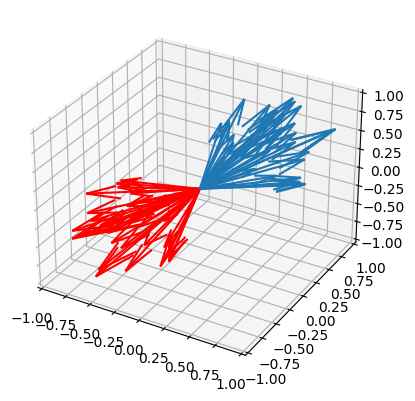

In [97]:
x = x[0, :, :, 0] # (latent_dim, 3)
x = x.detach().numpy()

x_rotated = x_rotated[0, :, :, 0] # (latent_dim, 3)
x_rotated = x_rotated.detach().numpy()

# plot all 3D vectors starting from origin
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(np.zeros(latent_dim), np.zeros(latent_dim), np.zeros(latent_dim), x[:, 0], x[:, 1], x[:, 2])
# in red
ax.quiver(np.zeros(latent_dim), np.zeros(latent_dim), np.zeros(latent_dim), x_rotated[:, 0], x_rotated[:, 1], x_rotated[:, 2], color='r')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

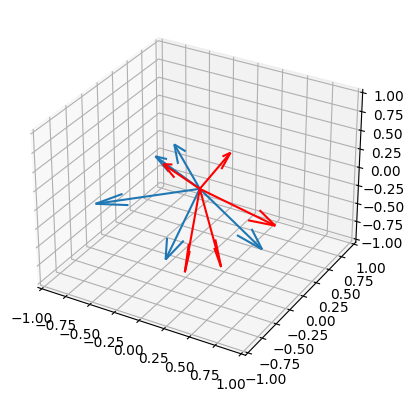

In [98]:
z_out = z_out[0, 0, :, :] # (3, num_latents)
z_out = z_out.detach().numpy()

z_rotated_out = z_rotated_out[0, 0, :, :] # (3, num_latents)
z_rotated_out = z_rotated_out.detach().numpy()

# plot all 3D vectors starting from origin
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(np.zeros(num_latents), np.zeros(num_latents), np.zeros(num_latents), z_out[0, :], z_out[1, :], z_out[2, :])
# in red
ax.quiver(np.zeros(num_latents), np.zeros(num_latents), np.zeros(num_latents), z_rotated_out[0, :], z_rotated_out[1, :], z_rotated_out[2, :], color='r')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
plt.show()

In [53]:
vnn_pointnet = VNN_SimplePointnet(513, 3, 128, 20, 'invariant_latent').to('cuda')

In [45]:
points = torch.rand(1, 20, 3).to('cuda')

x, c = vnn_pointnet(points)

In [46]:
c.shape

torch.Size([1, 513, 3])

In [49]:
# Generate a y axis rotation
rot = Rotation.from_euler('y', 0, degrees=True)

# Convert the rotation to a rotation matrix
rot_matrix_np = rot.as_matrix()

# Convert the numpy array to a PyTorch tensor
rot_tensor = torch.tensor(rot_matrix_np, dtype=torch.float).squeeze().to('cuda')

rot_points = torch.einsum('ij,bfj->bfi', rot_tensor, points)

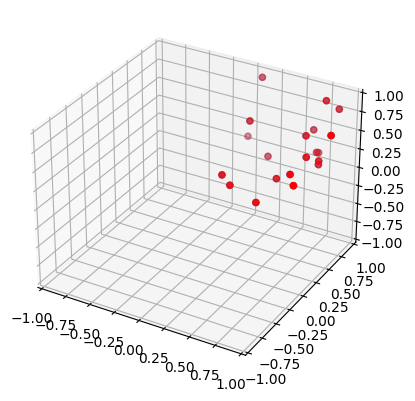

In [50]:
# plot points and rotated points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[0, :, 0].cpu(), points[0, :, 1].cpu(), points[0, :, 2].cpu())
ax.scatter(rot_points[0, :, 0].cpu(), rot_points[0, :, 1].cpu(), rot_points[0, :, 2].cpu(), color='r')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
plt.show()

In [57]:
x, c = vnn_pointnet(points)
x_rot, c_rot = vnn_pointnet(rot_points)

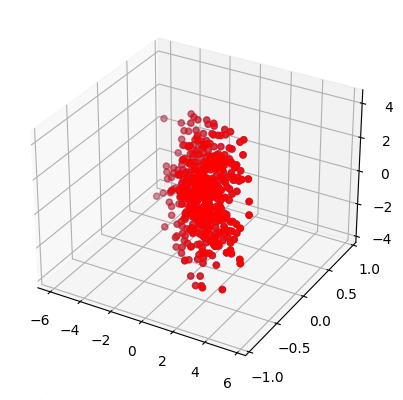

In [58]:
# plot c and c_rot
c = c.cpu().detach().numpy()
c_rot = c_rot.cpu().detach().numpy()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(c[0, :, 0], c[0, :, 1], c[0, :, 2])
ax.scatter(c_rot[0, :, 0], c_rot[0, :, 1], c_rot[0, :, 2], color='r')
plt.show()